In [1]:
import os
import sys
sys.path.append('../')
import io
import time
import json
import tensorflow as tf
from PIL import Image
import numpy as np
import multiprocessing
import concurrent.futures
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from utils.image_preprocessor import *
from TFRHelper import *

tf.executing_eagerly()
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
data_path = "/mnt/sata4/facial_landmarks"

In [181]:
def get_data(img_root, unparsed_data):
    data = unparsed_data.split(' ')

    img_path = os.path.join(img_root, data[0])

    landmarks = [float(x) for x in data[15:-1]]
    landmarks = np.reshape(landmarks, (-1 ,2)) # (68,2)
        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    face_bbox = get_face_roi2(img, landmarks, 192, 192, 1.0)
    face = crop_image(img, face_bbox)
    landmarks = get_new_landmark(landmarks, face_bbox)
   
    h, w, c = face.shape
    
    if h > w:
        padding = (h - w) // 2
        face = cv2.copyMakeBorder(face, 0, 0, padding, padding, cv2.BORDER_REPLICATE)
        landmarks = landmarks + [padding, 0]

    if w > h:
        padding = (w - h) // 2
        face = cv2.copyMakeBorder(face, padding, padding, 0, 0, cv2.BORDER_REPLICATE)
        landmarks = landmarks + [0, padding]

    if not is_img_valid(face):
        return None
    
    normed_landmark = landmarks / face.shape[:2]
    face = cv2.resize(face, (240, 240))
    lm = normed_landmark * 240
    
    boundary_map = get_boundary_map(lm.tolist(), face)
    boundary_map = np.transpose(boundary_map, [1,2,0])
    
    paf = get_paf(lm.tolist(), face)
    
    # for gaussian kernel
    '''
    w, h, c = boundary_map.shape
    input_tensor = np.reshape(boundary_map, (1, w, h, c))
    input_tensor = tf.cast(input_tensor, np.float32)
    boundary_map = tf.nn.depthwise_conv2d(input_tensor, kernel, strides=[1, 1, 1, 1], padding='SAME')[0]
    '''

    return img, face, normed_landmark, boundary_map, paf

def parse_txt_file(txt_path):
    with open(txt_path, 'r') as file:
        dt = file.read()
        file.close()
    dt = dt.split('\n')
    return dt

def get_boundary_map(pts2d, img):

    landmarks = pts2d

    jaw = landmarks[0:17]
    right_eyebrow = landmarks[17:22]
    left_eyebrow = landmarks[22:27]
    nose_vert = landmarks[27:31]
    nose_hori = landmarks[31:36]
    re_upper = landmarks[36:40]
    re_lower = landmarks[39:42] + landmarks[36:37]
    le_upper = landmarks[42:46]
    le_lower = landmarks[45:48] + landmarks[42:43]
    mouth_upper = landmarks[48:54] + landmarks[54:55]
    mouth_lower = landmarks[54:60] + landmarks[48:49]

    boundaries = [jaw,
                  right_eyebrow, left_eyebrow,
                  nose_vert, nose_hori,
                  re_upper, re_lower,
                  le_upper, le_lower,
                  mouth_upper, mouth_lower]
    h,w,c, = img.shape
    heatmap = []

    for landmark in boundaries:
        pad = 1
        pts = np.pad(landmark, [(pad,pad), (0,0)], mode='wrap')
        x, y = np.transpose(landmark)
        i = np.arange(0, len(landmark))

        interp_i = np.linspace(0, i.max(), 5 * i.size)

        xi = interp1d(i, x, kind='cubic')(interp_i)
        yi = interp1d(i, y, kind='cubic')(interp_i)

        pts = np.reshape(np.stack([xi, yi], 1), (-1, 2))
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1, 1, 2))

        temp = np.zeros((h, w))
        temp = cv2.polylines(temp, [pts], False, (200), 1)

        heatmap.append(temp)

    heatmap = np.reshape(heatmap, (len(boundaries), h, w))

    return heatmap

def create_gaussian_kernel(dot_size, num_channels):
    # make a canvas
    dot_size = dot_size * 2

    alpha = 24.0
    x_axis = tf.linspace(alpha, -alpha, dot_size)[:, None]
    y_axis = tf.linspace(alpha, -alpha, dot_size)[None, :]

    template = tf.sqrt(x_axis ** 2 + y_axis ** 2)
    template = tf.reduce_max(template) - template
    template = template / tf.reduce_max(template)

    kernel = tf.reshape([template] * num_channels, (num_channels, dot_size, dot_size, 1))
    kernel = tf.transpose(kernel, [1, 2, 0, 3])
    return kernel

def get_paf(lms, img):
    landmarks = lms

    jaw = landmarks[0:17]
    right_eyebrow = landmarks[17:22]
    left_eyebrow = landmarks[22:27]
    nose_vert = landmarks[27:31]
    nose_hori = landmarks[31:36]
    re_upper = landmarks[36:40]
    re_lower = landmarks[39:42] + landmarks[36:37]
    le_upper = landmarks[42:46]
    le_lower = landmarks[45:48] + landmarks[42:43]
    mouth_upper = landmarks[48:54] + landmarks[54:55]
    mouth_lower = landmarks[54:60] + landmarks[48:49]

    boundaries = [jaw,
                  right_eyebrow, left_eyebrow,
                  nose_vert, nose_hori,
                  re_upper, re_lower,
                  le_upper, le_lower,
                  mouth_upper, mouth_lower]
    
    boundaries = [np.array(p) for p in boundaries]
    h,w,c, = img.shape
    paf_x = []
    paf_y = []
    
    for landmark in boundaries:
        llandmark = landmark[1:]
        rlandmark = landmark[:-1]
        landmark = rlandmark
        
        pvec = llandmark - rlandmark
        px, py = np.transpose(pvec)
        x, y = np.transpose(landmark)
        
        i = np.arange(0, len(pvec))
        interp_i = np.linspace(0, i.max(), 5 * i.size)
        
        vectormap_x = np.zeros((h,w))
        vectormap_y = np.zeros((h,w))

        #px = interp1d(i, px, kind='cubic')(interp_i)
        #py = interp1d(i, py, kind='cubic')(interp_i)
        px = interp1d(i, px)(interp_i)
        py = interp1d(i, py)(interp_i)
        
        #xi = np.array(interp1d(i, x, kind='cubic')(interp_i), int)
        #yi = np.array(interp1d(i, y, kind='cubic')(interp_i), int)
        xi = np.array(interp1d(i, x)(interp_i), int)
        yi = np.array(interp1d(i, y)(interp_i), int)
        
        pvec = np.reshape(np.stack([px, py], 1), (-1, 2))
        #pts = np.reshape(np.stack([xi, yi], 1), (-1,2))
        unitvec = pvec / np.linalg.norm(pvec, axis=1)[:, None]
        px, py = np.transpose(unitvec)
        
        vectormap_x[xi, yi] = px
        vectormap_y[xi, yi] = py
        paf_x.append(vectormap_x)
        paf_y.append(vectormap_y)
        
        
        '''
        pts = pts.reshape((-1, 1, 2))
        temp = np.zeros((h, w))
        temp = cv2.polylines(temp, [pts], False, (200), 1)
        #print(normvec)
        '''
    paf = np.array([paf_x, paf_y])
    return paf
                              
        

In [22]:
all_txt_paths = [
#    "Menpo2D/Train/Menpo2D_profile_train.txt",
    "Menpo2D/Train/Menpo2D_semifrontal_train.txt",
#    "Menpo2D/Test/Menpo2D_profile_test.txt",
    "Menpo2D/Test/Menpo2D_semifrontal_test.txt",
#    "MultiPIE/MultiPIE_profile_train.txt",
    "MultiPIE/MultiPIE_semifrontal_train.txt",
    "300W/Train/300W_train.txt",
    "300W/Validation/300W_validation.txt",
    "300W/Test/300W_test.txt",
    "COFW/COFW.txt",
    "frgc/frgc_train.txt",
    "xm2vts/xm2vts_train.txt"
]

In [23]:
for txt_path in all_txt_paths:
    if os.path.exists(os.path.join(data_path, txt_path)):
        print(f"{txt_path} exists! - {os.path.dirname(txt_path)}")
    else:
        print(f"ERROR on {txt_path}")

Menpo2D/Train/Menpo2D_semifrontal_train.txt exists! - Menpo2D/Train
Menpo2D/Test/Menpo2D_semifrontal_test.txt exists! - Menpo2D/Test
MultiPIE/MultiPIE_semifrontal_train.txt exists! - MultiPIE
300W/Train/300W_train.txt exists! - 300W/Train
300W/Validation/300W_validation.txt exists! - 300W/Validation
300W/Test/300W_test.txt exists! - 300W/Test
COFW/COFW.txt exists! - COFW
frgc/frgc_train.txt exists! - frgc
xm2vts/xm2vts_train.txt exists! - xm2vts


In [24]:
counter = 0
for txt_path in all_txt_paths:
    all_data = parse_txt_file(os.path.join(data_path, txt_path))
    img_path = os.path.join(data_path, os.path.dirname(txt_path))
    fn = os.path.basename(txt_path)
    fn = os.path.splitext(fn)[0]
    print(os.path.dirname(txt_path), fn, len(all_data[:-1]))
    
#     for dt in all_data[:-1]:
#         img, bbox, facial_points, landmarks = parse_data(img_path, dt)
    print(len(all_data[:-1]))
    counter = counter + len(all_data[:-1])
#     for data in all_data:
        

Menpo2D/Train Menpo2D_semifrontal_train 6653
6653
Menpo2D/Test Menpo2D_semifrontal_test 5334
5334
MultiPIE MultiPIE_semifrontal_train 6665
6665
300W/Train 300W_train 3702
3702
300W/Validation 300W_validation 135
135
300W/Test 300W_test 600
600
COFW COFW 507
507
frgc frgc_train 4950
4950
xm2vts xm2vts_train 2360
2360


In [25]:
kernel = create_gaussian_kernel(10, 11)

/mnt/sata4/facial_landmarks/xm2vts
180.59393406593406
(458, 403, 3)
(240, 240, 3)


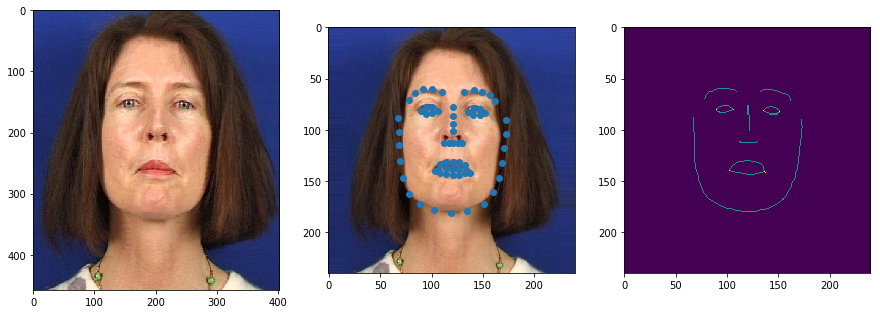

In [182]:
txt_path = np.random.choice(all_txt_paths)
all_data = parse_txt_file(os.path.join(data_path, txt_path))
img_root_path = os.path.join(data_path, os.path.dirname(txt_path))
print(img_root_path)

with open(os.path.join(data_path, txt_path), 'r') as file:
    dt = file.read()
    file.close()
dt = dt.split('\n')

i = np.random.randint(0, len(dt) - 1)

img, face, normed_landmark, boundary_map, paf = get_data(img_root_path, dt[i])
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

lm = normed_landmark * 240
print(np.max(lm))
x, y = np.transpose(lm)

print(img.shape)
print(face.shape)
#axes[0].imshow(img)
axes[0].quiver()
axes[1].imshow(face)
axes[1].scatter(x, y)
axes[2].imshow(np.sum(boundary_map, -1))

In [29]:
#bm = np.sum(boundary_map, -1)
print(boundary_map.shape)
x = np.arange(240)
y = np.arange(240)
#plt.quiver(x,y,)

(240, 240, 11)
